# Working with Logan Search results with Python in Jupyter

About **Logan Search** - A k-mer search engine for all Sequence Read Archive public accessions available in Logan:

https://x.com/RayanChikhi/status/1855925390155370962    November 2024
>"A k-mer index for the entire SRA, finally."
	https://x.com/p_peterlongo/status/1855889588604031105
	>"There are 50 petabases of freely-available DNA sequencing data. We introduce "Logan Search" which allows you to search for any DNA sequence in minutes, bringing Earth’s largest genomic resource to your fingertips.
	🏔️ https://logan-search.org 🏔️"
	>"Under the hood, we built a 1 petabyte k-mer index for all 27 million sequencing datasets in the SRA up to 12-2023."
	>"Logan Search transforms your query🧬 to its k-mers🔢 (k=31), and in the time it takes to brew a coffee, it will retrieve every dataset containing your k-mers. It’s the only service working at this scale"

https://bsky.app/profile/rayanchikhi.bsky.social/post/3lhc2bxavas2h  February 2025
>"We have updated all Logan contigs, now at version 1.1! Contiguity has been much improved (2x) and a duplicated k-mers bug has been fixed. More information and changelog here:"
>"For more context: Logan is a collection of all public sequencing data (until end of 2023) assembled into contigs. It is freely hosted on the cloud, and contains hundreds of terabytes of valuable genomic data: https://github.com/IndexThePlanet/Logan "


Therefore, the results give you information for a single search sequence across the entire [Sequence Read Archive (SRA)](https://www.ncbi.nlm.nih.gov/sra), surveying  accessions/datasets where that sequence occurs. (Note that although it is stated '**all** public sequencing data (until end of 2023)', that it is more specifically stated as 96% elsewhere, see [here](https://github.com/IndexThePlanet/Logan/issues/7#issuecomment-2378745522) for further details.)


**The web interface the results are presented in let's you easly examine things, such as a bar plot with the count the organims represented by the surveyed accessions/datasets, available via the 'Plot' button.** However, after working with Logan Search some, you may want to combine results for different sequences to see if you can learn something. The web interface they provide doesn't seem to allow this, yet with a Python/Jupyter combination we can do this easily.  
This notebook begins to illustrate that.

Proof of principle Demonstration:

**QUESTION**: Can you use multiple sets of query results to get information about splicing isoforms for a gene?

Exploaratory Case study:

##### *USP7* transcript isoforms

*USP7* was among the additional 35 genes indicated to have alternate splicing variant isoforms with diagnostic properties in [Blakes et al 2022 'A systematic analysis of splicing variants identifies new diagnoses in the 100,000 Genomes Project'](https://genomemedicine.biomedcentral.com/articles/10.1186/s13073-022-01087-x). The 35 was beyond any participants whose case was already solved through 100,000 Genomes Project, that the study also included.

The transcript table for *USP7* can be seen by going to [here]( https://useast.ensembl.org/Homo_sapiens/Transcript/Summary?db=core;g=ENSG00000187555;r=16:8895045-8956380;t=ENST00000344836) and clicking on the button 'Show transcript table' to the right of the 'Gene' line, which is below the 'About this transcript' line. That will toggle on displaying the transcript table.

The first line in that table shows the the MANE Select transcript with a Transcript Support Level (TSL) rating of 1.  
You can read about [Transcript Support Level (TSL) flags here](https://useast.ensembl.org/info/genome/genebuild/transcript_quality_tags.html).  
Note that several lower in the table retain an intron and only have a TSL rating of 4.  
Can we observe among SRA accessions for human sequences less representation for those USP7 transcripts with lower levels of support?  
And maybe even more compelling as a proof of the possibilities Logan Search may enable, can we find evidence of one of these TSL4-rated transcripts using Logan Search to identify accessions to further examine? 

(Note, as you see below this raised some issues with the submission, such as should the 'Groups' be limited to `Transcriptomic_human` that probably should be considered further, and so consider this still in the Exploratory phase. However, it is sufficient at this stage for illustrating some use of this type data with Python in Jupyter.)

-----

#### Preparation

Several Logan Search queries were done with sequences derived from the MANE Select transcript as well as the TSL4-rated [ENST00000567329 (USP7-217)](https://useast.ensembl.org/Homo_sapiens/Transcript/Exons?db=core;g=ENSG00000187555;r=16:8895045-8956380;t=ENST00000567329). It has a retained intron. (This is reflected later in a tag name, `RET_I`.)

For the submission of these queries, the threshhold was set to 1.0 and settings for the 'Groups' was the following for all the queries:

```text
Groups:
Transcriptomic_human
Transcriptomic
```

The notebook assumes data is placed in a directory named `logan_search_results`; however, you can edit the code below

At this time, the expectation is one results directory per related gene.

#### Reading in the results for several queries

Run the code in the next cell assigning the settings to match the set-up preparation performed and to bring in the results data to the active namespace:

In [1]:
results_dir = "/home/jovyan/logan_search_results/"
consistent_part_of_file_name_suffix = "_31mer_"

import os
import fnmatch
import pandas as pd

def extract_tags_from_filename(filename):
    '''
    extract tag labels from file names

    return the tag label
    '''
    first_part = filename.split(consistent_part_of_file_name_suffix,1)[0]
    all_but_first_part_of_remainder_as_list = first_part.split("_")[1:]
    return "_".join(all_but_first_part_of_remainder_as_list)
    
matched_filenames = []
file_tags_per_file = []
dfs = []
for file in sorted(os.listdir(results_dir)):
    if fnmatch.fnmatch(file, '*.tsv'):
        matched_filenames.append(file)
        file_tags_per_file.append(extract_tags_from_filename(file))
        dfs.append(pd.read_csv(results_dir + file, sep="\t"))

# provide feedback about what was read in
max_filename_length = max(len(filename) for filename in matched_filenames)
for filename, df in zip(matched_filenames, dfs): 
    print(f'from {filename}:{" " * (max_filename_length - len(filename))} {len(df):>6} rows read in')

#print(file_tags_per_file) # FOR DEBUGGING, uncomment
#print(matched_filenames) # FOR DEBUGGING, uncomment
gene_name = file_tags_per_file[0].split("_",1)[0]
# make tuples of tag labels and corresponding dataframes
tags_and_dataframes = list(zip(file_tags_per_file, dfs)) # tags are first in each two-item tuple, the dataframe is second
# make dictionary of tuples of tag labels and corresponding dataframes, integers will be the keys with the tuples as values
tags_and_dataframes_dict = dict(zip(range(len(file_tags_per_file)), zip(file_tags_per_file, dfs))) # integers ('index') are keys with tags are first in each two-item tuple, the dataframe is second
print(f"\nTOTAL QUERY RESULTS READ IN: {len(file_tags_per_file)}")

from human_USP7_RET_I_31mer_logan_results.tsv:       19999 rows read in
from human_USP7_SJ_14n15_31mer_logan_results.tsv:    19999 rows read in
from human_USP7_SJ_34_31mer_logan_results.tsv:       19997 rows read in
from human_USP7_TSL4_altSJ_31mer_logan_results.tsv:  19997 rows read in

TOTAL QUERY RESULTS READ IN: 4


I had it print in the number of rows read from the results files.

-------

**Aside**:

Since I printed the number of rows read in from the Logan Search results files, I'd like to discuss what it shoed for a minute.

Remember the Logan Search says, "The top 20k hits are returned." So I'm not quite sure why it isn't quite 20K for any one of these and why the total numbers aren't all equal but slightly less than one another, save the two that are 19997. Does this point to a data munging issue?

I don't think so because I see similar when the working directory is `/home/jovyan/logan_search_results` and I run the following code:

```bash
!wc -l human_USP7_RET_I_31mer_logan_results.tsv
!wc -l human_USP7_SJ_14n15_31mer_logan_results.tsv
!wc -l human_USP7_SJ_34_31mer_logan_results.tsv
!wc -l human_USP7_TSL4_altSJ_31mer_logan_results.tsv
```

Gives:

```text
19999 human_USP7_RET_I_31mer_logan_results.tsv
19999 human_USP7_SJ_14n15_31mer_logan_results.tsv
19997 human_USP7_SJ_34_31mer_logan_results.tsv
19997 human_USP7_TSL4_altSJ_31mer_logan_results.tsv
```

So it isn't Pandas. But why are numbers the same as the values for 'rows read in'? Accounting for the header line should add one to all the values seen for 'rows read in' relative to when using bash to print number of lines. Indeed, when I did `!head human_USP7_SJ_14n15_31mer_logan_results.tsv > human_USP7_test.tsv` and then read in `human_USP7_test.tsv` it says it read in 9 rows and `!wc -l human_USP7_test.tsv` gives `10` because it includes the header. So that makes sense. (But looking at it in Jupyter's text editor, I see 20 lines of content and one extra line that looks empty and this agrees with what I saw locally in my text editor.) But why doesn't `!wc -l` with the actual full `.tsv`s make accurate sense relative to Pandas?  
None of this changes the overall conclusions here, but it is midly concerning to see things not quite adding up and all being equal.

I did quite a lot to investigate this further but other than different type of line endings, I'm not seeing anything to cause this one-off issue. (Or even why `wc -l` disagrees with my text editor while being one-off from Pandas.)

`-------------------`end of **Aside**`-------------------`end of **Aside**`-------------------`
____

#### Visualizing the results of the individual queries in a single plot

Run the next cell to make the plot.

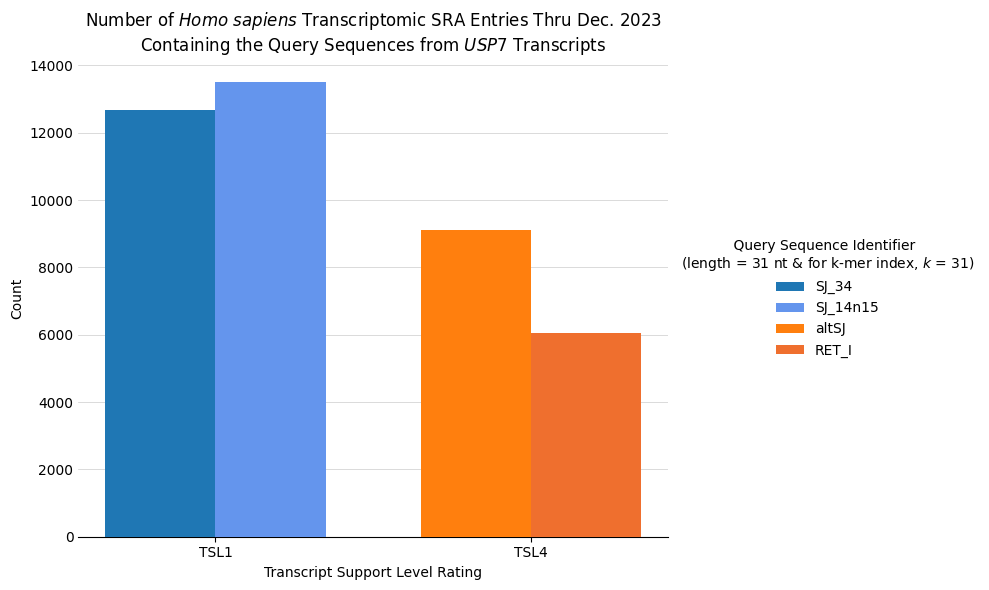

In [2]:
%run -i my_visualization.py

Before discussing those results, I want to say a few things about the code for that plot and how it is being run here in the light of this being a demonstration notebook.   
This demonstration notebook utilizes an external code file for plot generation, deviating from the typical self-contained Jupyter notebook structure. While Jupyter excels at integrating code and content to make something often called literate computing, this separation, achieved via `%run -i`, allows for a cleaner presentation and provides valuable resources for those looking to adapt this notebook and code. The external file contains 'commented-out' developmental stages of the featured plot. Users can explore and adapt [this visualization code](my_visualization.py).  
A related plot variation is also included in the notebook's final cell. 

Finally, this is only meant to give you a taste for the possibilities in data visualization. There's many more ways to take things and you'll need to adapt it based on your own sequences. For example, these all corresponded to splice junctions; however, imagine if some of query sequences corresponded to exons that occur in multiple mRNA isoforms. Then you may want to further illustrate that by adding something akin to the panel of [an Upset plot](https://upset.app/implementations/) showing association / combination matrix section in order to display the information about membership of exons and splice junctions relative individual transcripts, like in this illustrative example image:

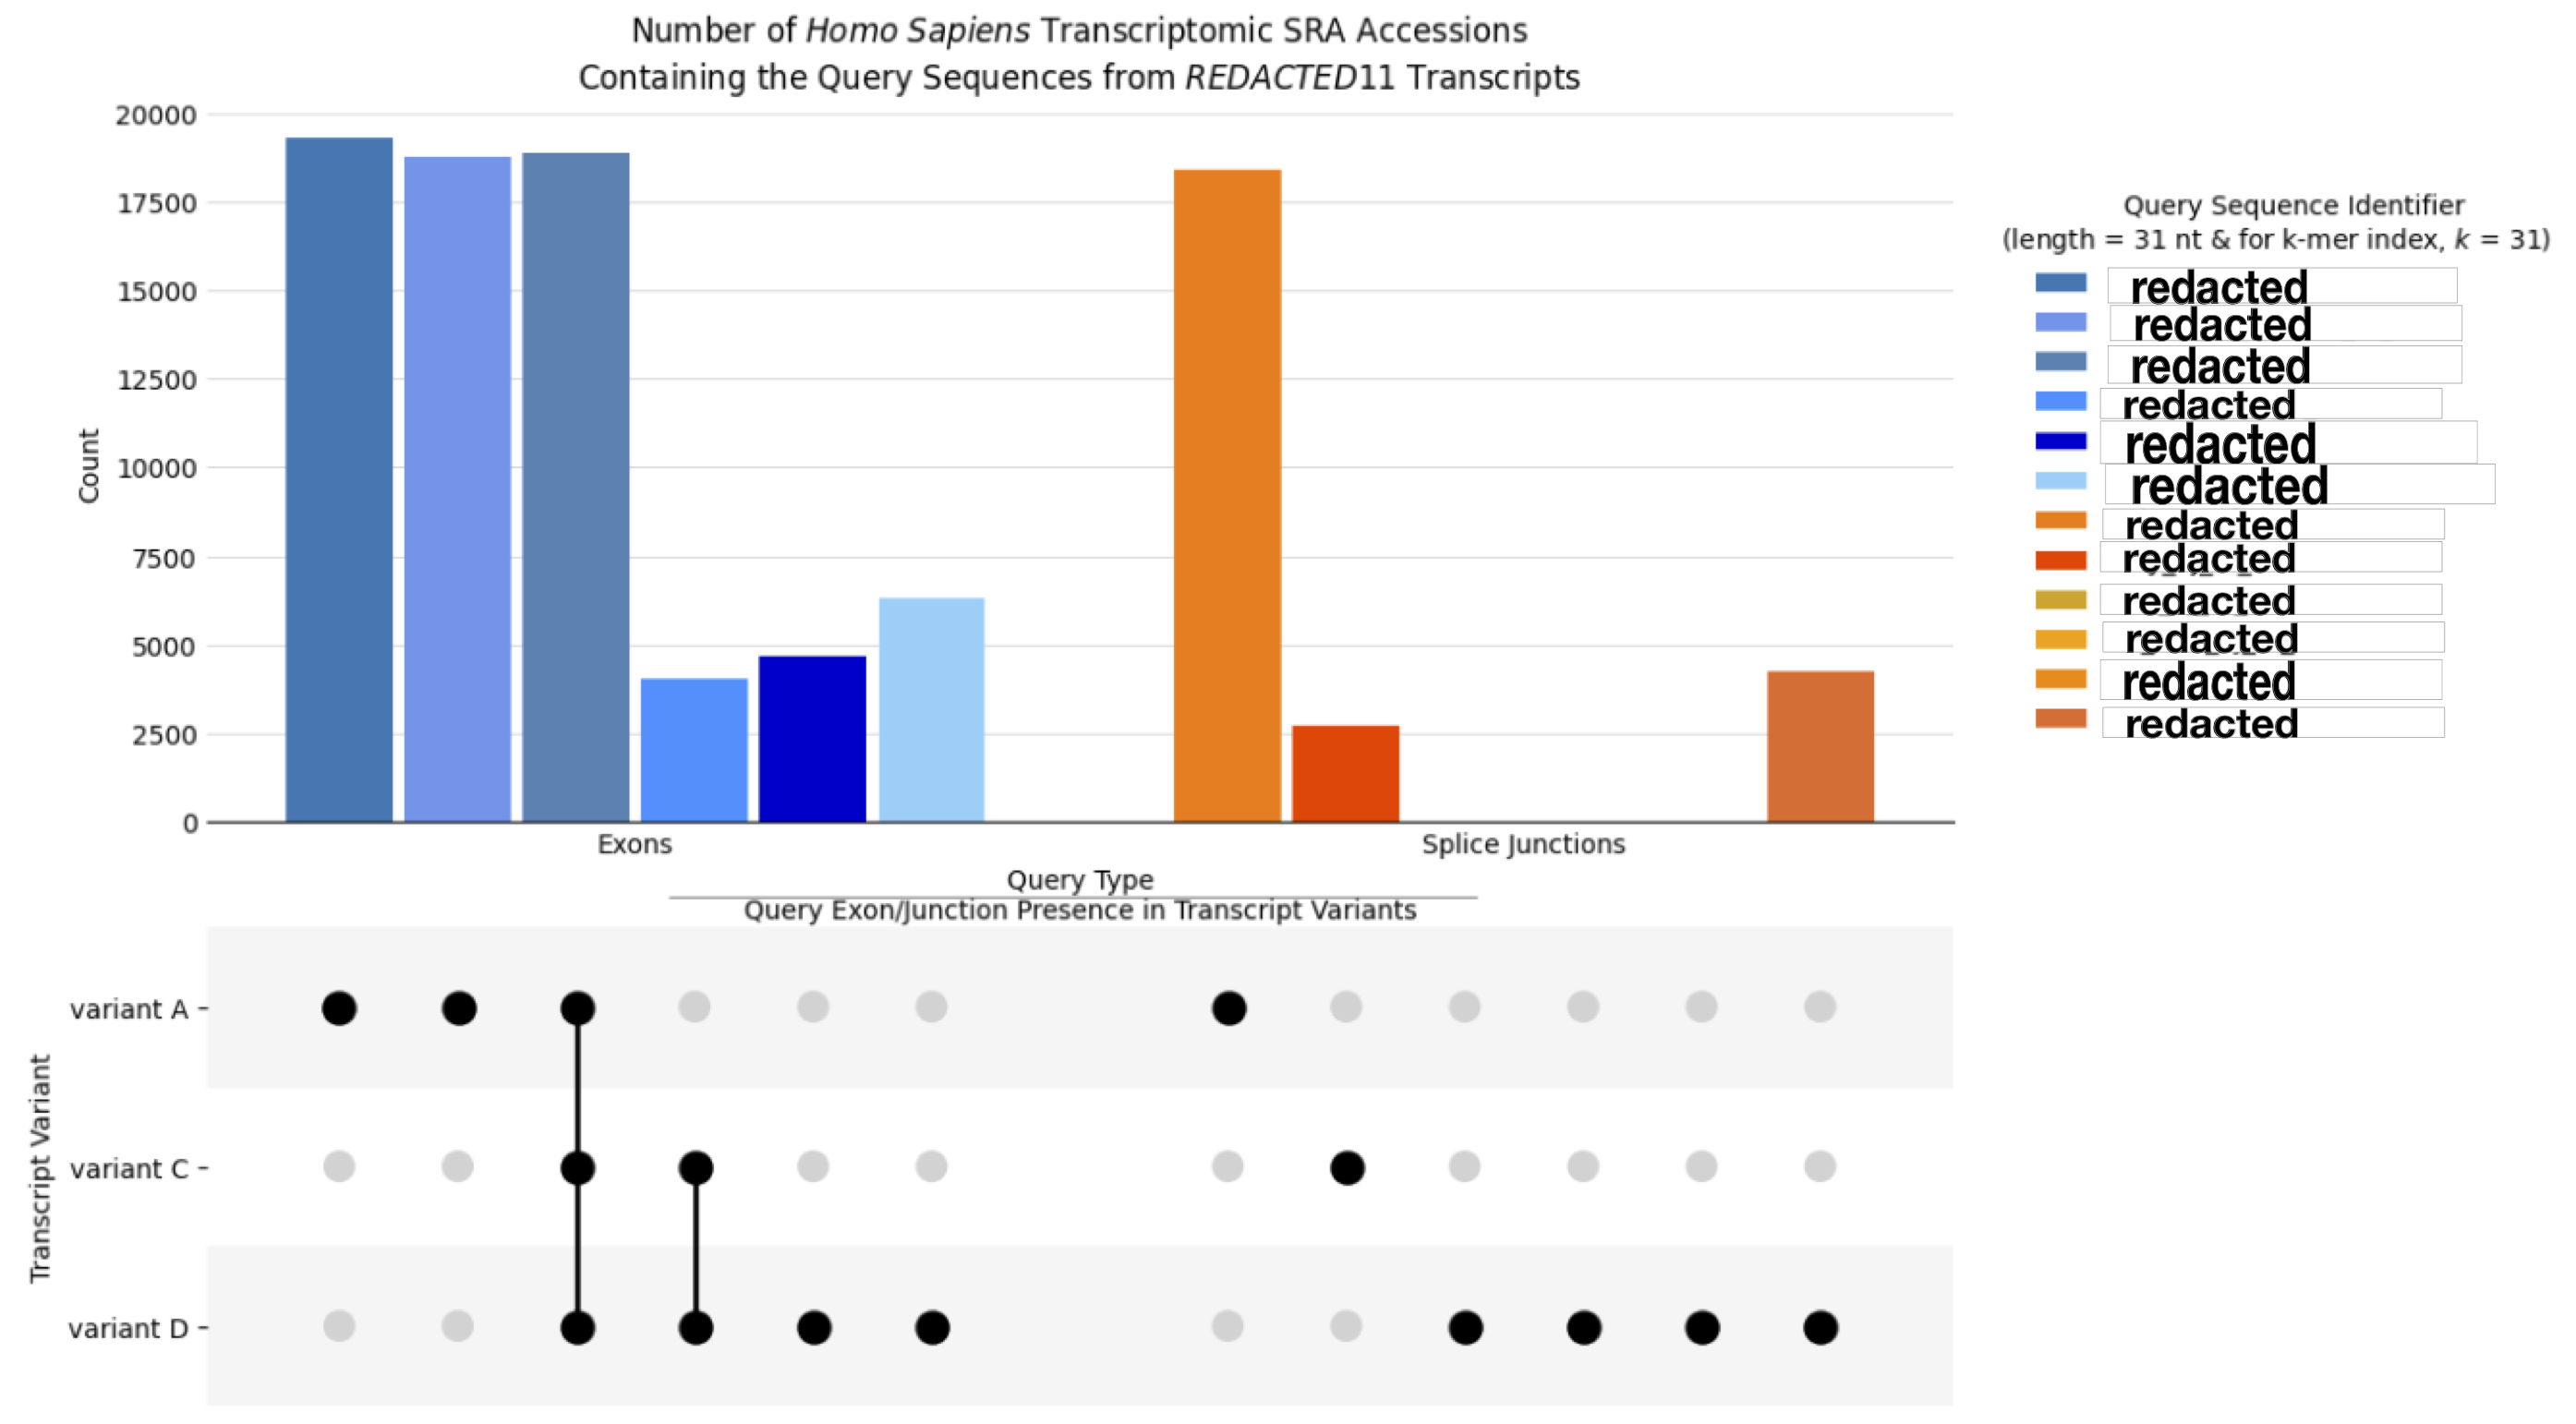

As this notebook is meant to offer examples that can be built upon, there is code that will add such a panel below in [this auxillary technical notebook](adding_mock_association_data_to_grouped_barplot.ipynb). That notebook is 'technical' because although it uses the same input data as here, the panel added is not grounded in any biological reality and is only for illustrating use of the code to produce such a figure if you had relevant data.

Now it is time to get back discussing what last run plot shows for this data.  
To make it easier to see in relation to the results discussion to follow, let's show the plot figure again. Instead of generating the entire plot again by running `%run -i my_visualization.py`, we can just recall the assigned active figure object on the last line of a cell, like so:

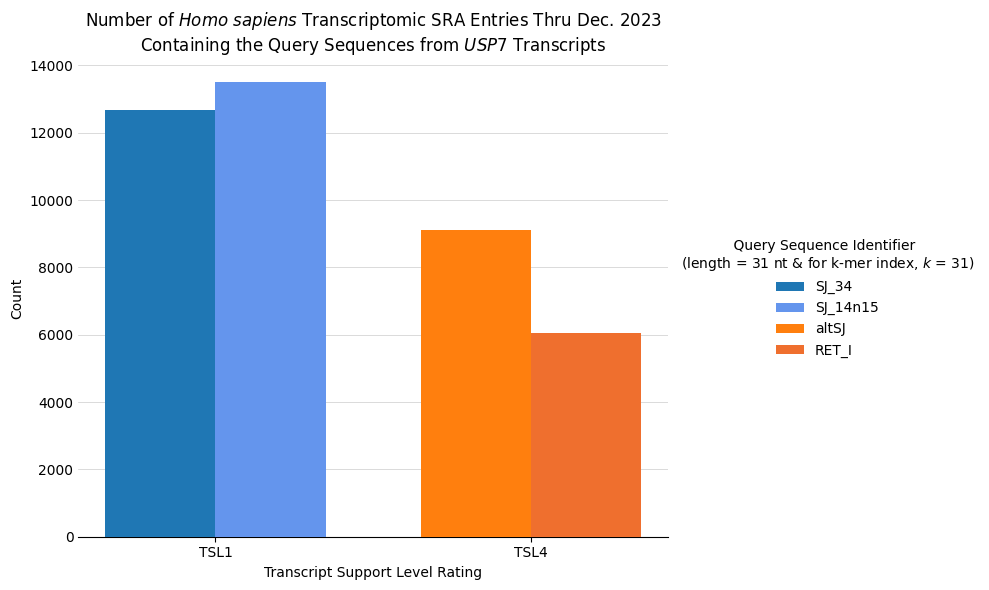

In [3]:
plot.figure

### Results

Clearly the well-supported USP7 splice junctions ([Transcript Support Level (TSL)](https://useast.ensembl.org/info/genome/genebuild/transcript_quality_tags.html) 1) from the MANE Select transcript  indicated with blue colors are more represented in SRA data than those of the orange splice junctions which come from a [TSL4](https://useast.ensembl.org/info/genome/genebuild/transcript_quality_tags.html)-rated transcript.   
 
You'll recall above where 'rows read in' was shown that all the results `.tsv` files had roughly the same content. What's the rest?  
Investigating the results in `human_USP7_RET_I_31mer_logan_results.tsv` in the Logan Search's web interface had already indicated a lot of hits to monkey. So those monkey accessions seem to fill up the SRA entries reported first?   
Can we show the many, many hits to monkey here? 

Running this next cell illustrates that I see a lot of that query sequence in  *Macaca mulatta* and *Macaca fascicularis* in the results in `human_USP7_RET_I_31mer_logan_results.tsv:

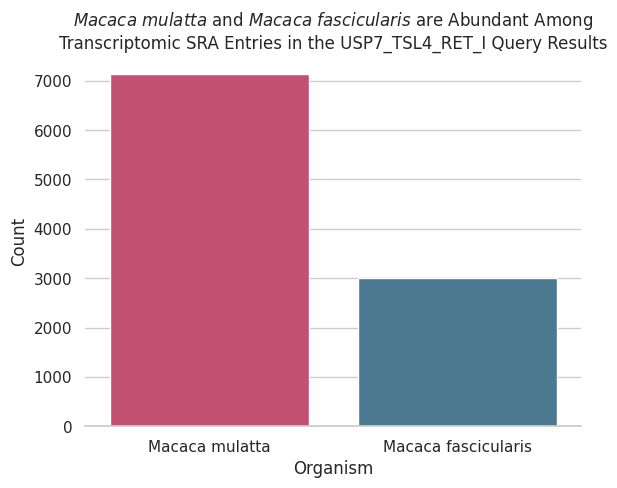

In [4]:
# Look at *Macaca mulatta* and *Macaca fascicularis* in data for `USP7_TSL4_SJ`
import seaborn as sns
RET_df = tags_and_dataframes_dict[0][1]

import seaborn as sns
import matplotlib.pyplot as plt

# Filter the DataFrame
filtered_df = RET_df[RET_df['organism'].isin(['Macaca mulatta', 'Macaca fascicularis'])]

# Count occurrences of each organism
organism_counts = filtered_df['organism'].value_counts()

# Create the bar plot using seaborn
#sns.barplot(x=organism_counts.index, y=organism_counts, hue=organism_counts.index, palette = sns.color_palette("Set2",2))
#sns.barplot(x=organism_counts.index, y=organism_counts, hue=organism_counts.index, palette = sns.diverging_palette(220, 20, n=2))
sns.set_theme(style="whitegrid")
g = sns.barplot(x=organism_counts.index, y=organism_counts, hue=organism_counts.index, palette = sns.diverging_palette(0, 230, n=2))
# Despine the plot (remove top and right spines and y-axis line)
g.spines['top'].set_visible(False)
g.spines['right'].set_visible(False)
g.spines['left'].set_visible(False)
plt.xlabel('Organism')
plt.ylabel('Count')
plt.title('$\mathit{Macaca\ mulatta}$ and $\mathit{Macaca\ fascicularis}$ are Abundant Among\nTranscriptomic SRA Entries in the USP7_TSL4_RET_I Query Results')
plt.show()

That search query sequence must match well to a lot of *Macaca mulatta* and *Macaca fascicularis* entries, and so those come up substantially, it seems. Probably filling in the gap made by a reduced amount of human?  
It is interesting that the organism seen in the majority of the total `RET_I` results is so close to humans, for which the query sequence was designed. While `Transcriptomic_human` was in the 'groups' applied, I also included `Transcriptomic`. And so I expect that could have allowed for non-human results, and so I cannot yet attribute this as being caused [imperfect nature of the 'groups'](https://github.com/IndexThePlanet/LoganSearch/issues/8) you can apply at submission. I'd have to re-run this search with the 'Transcriptomic_human' group to see what happens because I would imagine that something so close to humans might still come up in the imperfect 'Transcriptomic_human' group.

Whatever the source, the abundant representation in the results for `RET_I` leads to the question of whether the sequence causing the match is related to the USP7 ortholog in rhesus macaque or some other gene entirely? Learning that would require some additional exploration that is beyond the scope needed here for now.

And this does bring up one metric that can be used to decide if results from a query sequence are valuable or should not be necessarily considered in favor of a 'better' query. You could imagine setting a cut-off for the percent of results returned to your organism of interest since, at present, you cannot limit the query to accessions of a particular organism, although there are [imperfect 'groups'](https://github.com/IndexThePlanet/LoganSearch/issues/8) you can apply at submission. 


Before concluding the discussion of the present results, let's a donut plot to visualize the percent of results returned for the organisms of interest

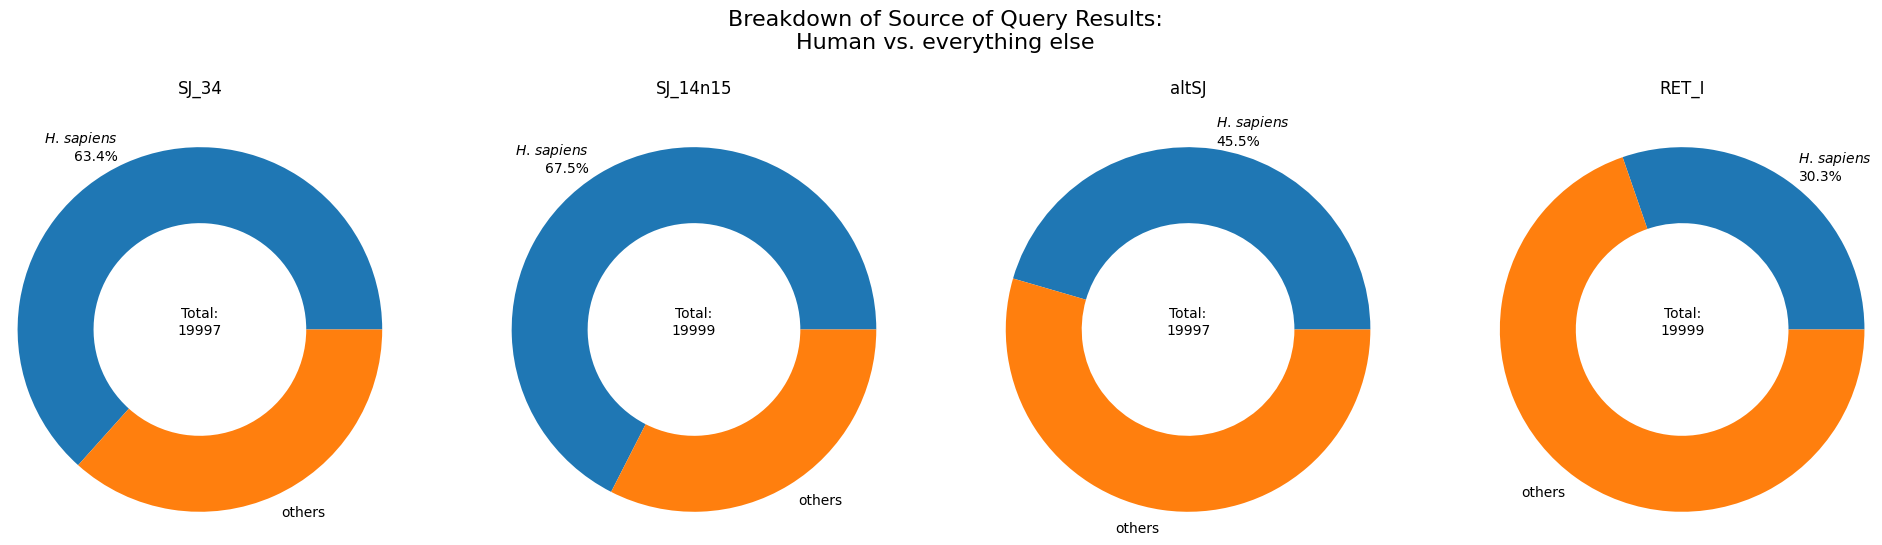

In [5]:
import matplotlib.pyplot as plt
plt.style.use('default') # if don't have this then the Macaca mulatta  and Macaca fascicularis plot make the colors dark because of the `sns.set_theme(style="whitegrid")`.
# Set up breakdown groups
organisms_groupings = ["Homo sapiens", "others"]

# Calculate counts for each dataframe
human_counts = [df['organism'].value_counts()['Homo sapiens'] if 'Homo sapiens' in df['organism'].values else 0 
         for df in dfs]
other_counts = [len(df) - human_counts[indx] for indx,df in enumerate(dfs)]
# Create a DataFrame for plotting
labels = [simplifytags(x) for x in file_tags_per_file]
donut_plot_df = pd.DataFrame({
    'Query': labels if labels else [f'Dataset {i+1}' for i in range(len(dfs))],
    organisms_groupings[0]: human_counts,
    organisms_groupings[1]: other_counts,
})
#print(donut_plot_df)
#print(len(labels))

# Create desired_order
desired_order = [labels[2],labels[1],labels[3], labels[0]]  # Replace with your actual k-mer names

# Reorder the dataframe based on desired_order
# Method: Using categorical data type (better if dealing with named categories)
donut_plot_df['Query'] = pd.Categorical(donut_plot_df['Query'], categories=desired_order, ordered=True)
donut_plot_df = donut_plot_df.sort_values('Query')
donut_plot_df = donut_plot_df.reset_index(drop=True) # Reset the index after sorting

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

fig.suptitle('Breakdown of Source of Query Results:\nHuman vs. everything else', fontsize=16, y=1.05) # Adjusted y parameter

for i, ax in enumerate(axes):
    count_data = [donut_plot_df.loc[i,organisms_groupings[0]], donut_plot_df.loc[i,organisms_groupings[1]]]
    hum_percent = donut_plot_df.loc[i,organisms_groupings[0]]/(donut_plot_df.loc[i,organisms_groupings[0]] + donut_plot_df.loc[i,organisms_groupings[1]])
    labels_lst = ['$\it{H}$. $\it{sapiens}$' + f"\n{hum_percent:.1%}",organisms_groupings[1]]
    #print(count_data)
    #ax.pie(count_data, labels=organisms_groupings, radius=1.2, wedgeprops={'width': 0.5})
    ax.pie(count_data, labels=labels_lst, radius=1.2, wedgeprops={'width': 0.5})
    ax.set_title(donut_plot_df.loc[i,'Query'], y=1.1)
    ax.text(0, -0.03, f'Total:\n{count_data[0] + count_data[1]}', ha='center')

#plt.savefig('Breakdown_donuts.png')
plt.tight_layout()
plt.show()

I would suspect that seeing something like the one for `RET_I` constrasting a bit with the others may give you pause and so this type of step chould be used as an assessment to screen for consistent characteristics of query sequences. With the idea to perhaps not consider the results of such a contrasting one alongside the others. Or at least highlight these inconsistencies so the results can be considered in that light. Actually because the group `Transcriptomic` was included, that is probably just filling up the space left by not enough human ones with this sequence and so in this case, I don't think any special consideration is needed. However, you may see something more extreme and mentioning such considerations may be appropriate in that light.

Before the aside for the breakdown of the results by organism I was disussing that while at present you cannot limit the query to entries of a particular organism, there are [imperfect 'groups'](https://github.com/IndexThePlanet/LoganSearch/issues/8) you can apply at submission.

Such 'Groups' were applied here, but **maybe I should have only used `Transcriptomic_human`**, and not also `Transcriptomic`? Because of the limitation at this time of one search per day, I was being less strict to collect data to start to analyze and not testing the upshot of restricting the groups as much as I should.  Yet, since they are imperfect as discussed [there](https://github.com/IndexThePlanet/LoganSearch/issues/8), they may not end up even working 100% to elminate the adundance of rhesus macaque results? 

Since we are on the subject of related metrics...  
In fact, because these were 31-mer queries and *k* is 31 for the k-mer index, I set the threshold to 1.0 for submission to limit to a perfect match; however, the range of the `kmer_coverage` should definitely be considered in initial assessment steps and possibly used to apply cut-offs if you aren't using 31-mer queries. (Along that line, I found [this discussion](https://github.com/IndexThePlanet/LoganSearch/issues/2) about using query sequences longer than the database *k* value of 31 particularly helpful when considering the concept of `kmer_coverage` relative to what mismatches mean to the `kmer_coverage` value.) Alternatively, even with 31-mer queries, if you aren't getting much you may want to lower the threshold from 1.0 to see what you collect and look at the details there. You could imagine SNPs and things interfering with identification of related accessions if you are considering material from individuals or populations where the 'standard' allele may not hold.

--------

This has revealed that less respresentation among records in the SRA for less supported transcripts may be evident using Logan Search results. Importantly you could use this as a way to identify accessions that potentially contain such support. (Long-read technology may add particular insightful in this regard, and so for more about selecting entries, see the next notebook in this series, [Selecting Logan Search results by Sequencing Technology using Python in Jupyter](Selecting_Logan_Search_results_by_Sequencing_Technology_using_Python_in_Jupyter.ipynb).) Of course, more rigorous study would need to be done with more splice junctions from this transcript, along with exons, and even features of transcripts from other genees.

Since this effort was meant to illustrate how you may work with such data with Python in Jupyter, this document is probably sufficient at this time. I think it brought up some interesting considerations that could be further explored. Primary among those is probably what if **I limit the 'Groups' setting to `Transcriptomic_human`** when submitting to Logan Search?


------


That concludes this demonstration notebook. However, you should be able to edit it or take the approach and customize it further to  investigate the data in your own multiple sets of query results.

See the next notebook in this series, [Selecting Logan Search results by Sequencing Technology using Python in Jupyter](Selecting_Logan_Search_results_by_Sequencing_Technology_using_Python_in_Jupyter.ipynb), where work with one of the results examples used here is extended with selection for entries of a particular type of sequencing technology.

-----

Enjoy!